In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
from scipy.spatial import distance

In [3]:
# Read the dataset
file_path = '/Users/irasafonik/Desktop/kaggle/spotify-2023.csv'

df = pd.read_csv(file_path, encoding='latin-1')

df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## 1. Basic information

### How many rows and columns? 

In [4]:
ncols, nrows = df.shape
print(f'Dataset has {ncols} rows and {nrows} columns')

Dataset has 953 rows and 24 columns


### Are there duplicated rows? 

In [5]:
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 0 rows that are duplicated, which means each row in the DataFrame is unique.
So that we do not need to continue processing duplicate lines


### What is the current data type of each column?

In [6]:
df.dtypes.to_frame('Data Type')

,Data Type
track_name,object
artist(s)_name,object
artist_count,int64
released_year,int64
released_month,int64
released_day,int64
in_spotify_playlists,int64
in_spotify_charts,int64
streams,object
in_apple_playlists,int64


To better understand columns of type object, we will analyze them into each subtype using function open_object_dtype()

In [7]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return dtypes

obj_cols = df.select_dtypes(include='object').columns
df[obj_cols].apply(open_object_dtype, axis=0).to_frame('Data Type')

,Data Type
track_name,{<class 'str'>}
artist(s)_name,{<class 'str'>}
streams,{<class 'str'>}
in_deezer_playlists,{<class 'str'>}
in_shazam_charts,"{<class 'str'>, <class 'float'>}"
key,"{<class 'str'>, <class 'float'>}"
mode,{<class 'str'>}


We can observe that there are two columns with inappropriate data types:

in_shazam_charts, key: they contain a mix of str and float types.

This inconsistency might be due to the presence of NaN values in these columns, as NaN is of type float

### Missing values in each row 

In [8]:
# Missing values in each row
missing_values_per_row = df.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (df.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

817 row(s) have 0 missing values
127 row(s) have 1 missing values
9 row(s) have 2 missing values
Total number of rows with missing values: 136


## 2. Data Distribution

### 2.1 Numerical columns 
We need to extract all numerical columns and store them in the variable numerical_cols

In [9]:
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]
numerical_cols.shape

(953, 17)

There are 17 numerical columns, let's see 5 sample rows of them

In [10]:
numerical_cols.sample(5)

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
584,2,2020,7,24,12854,0,237,27,0,91,70,76,72,22,0,27,4
20,3,2023,6,22,332,26,11,163,4,140,65,87,74,22,0,42,4
16,1,2023,2,24,2942,77,91,212,6,120,78,76,59,43,0,34,3
928,1,2022,10,14,991,0,36,38,0,162,74,22,67,0,0,11,46
296,1,2002,1,1,32502,21,247,54,1,171,70,6,73,1,0,36,26


👉 What is the percentage of missing values?

To start our analysis, we first examined the numerical columns using the info() method.

In [11]:
numerical_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   artist_count          953 non-null    int64
 1   released_year         953 non-null    int64
 2   released_month        953 non-null    int64
 3   released_day          953 non-null    int64
 4   in_spotify_playlists  953 non-null    int64
 5   in_spotify_charts     953 non-null    int64
 6   in_apple_playlists    953 non-null    int64
 7   in_apple_charts       953 non-null    int64
 8   in_deezer_charts      953 non-null    int64
 9   bpm                   953 non-null    int64
 10  danceability_%        953 non-null    int64
 11  valence_%             953 non-null    int64
 12  energy_%              953 non-null    int64
 13  acousticness_%        953 non-null    int64
 14  instrumentalness_%    953 non-null    int64
 15  liveness_%            953 non-null    int64
 16  speechin

In [12]:
numerical_cols.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


👉 Distribution of numerical columns

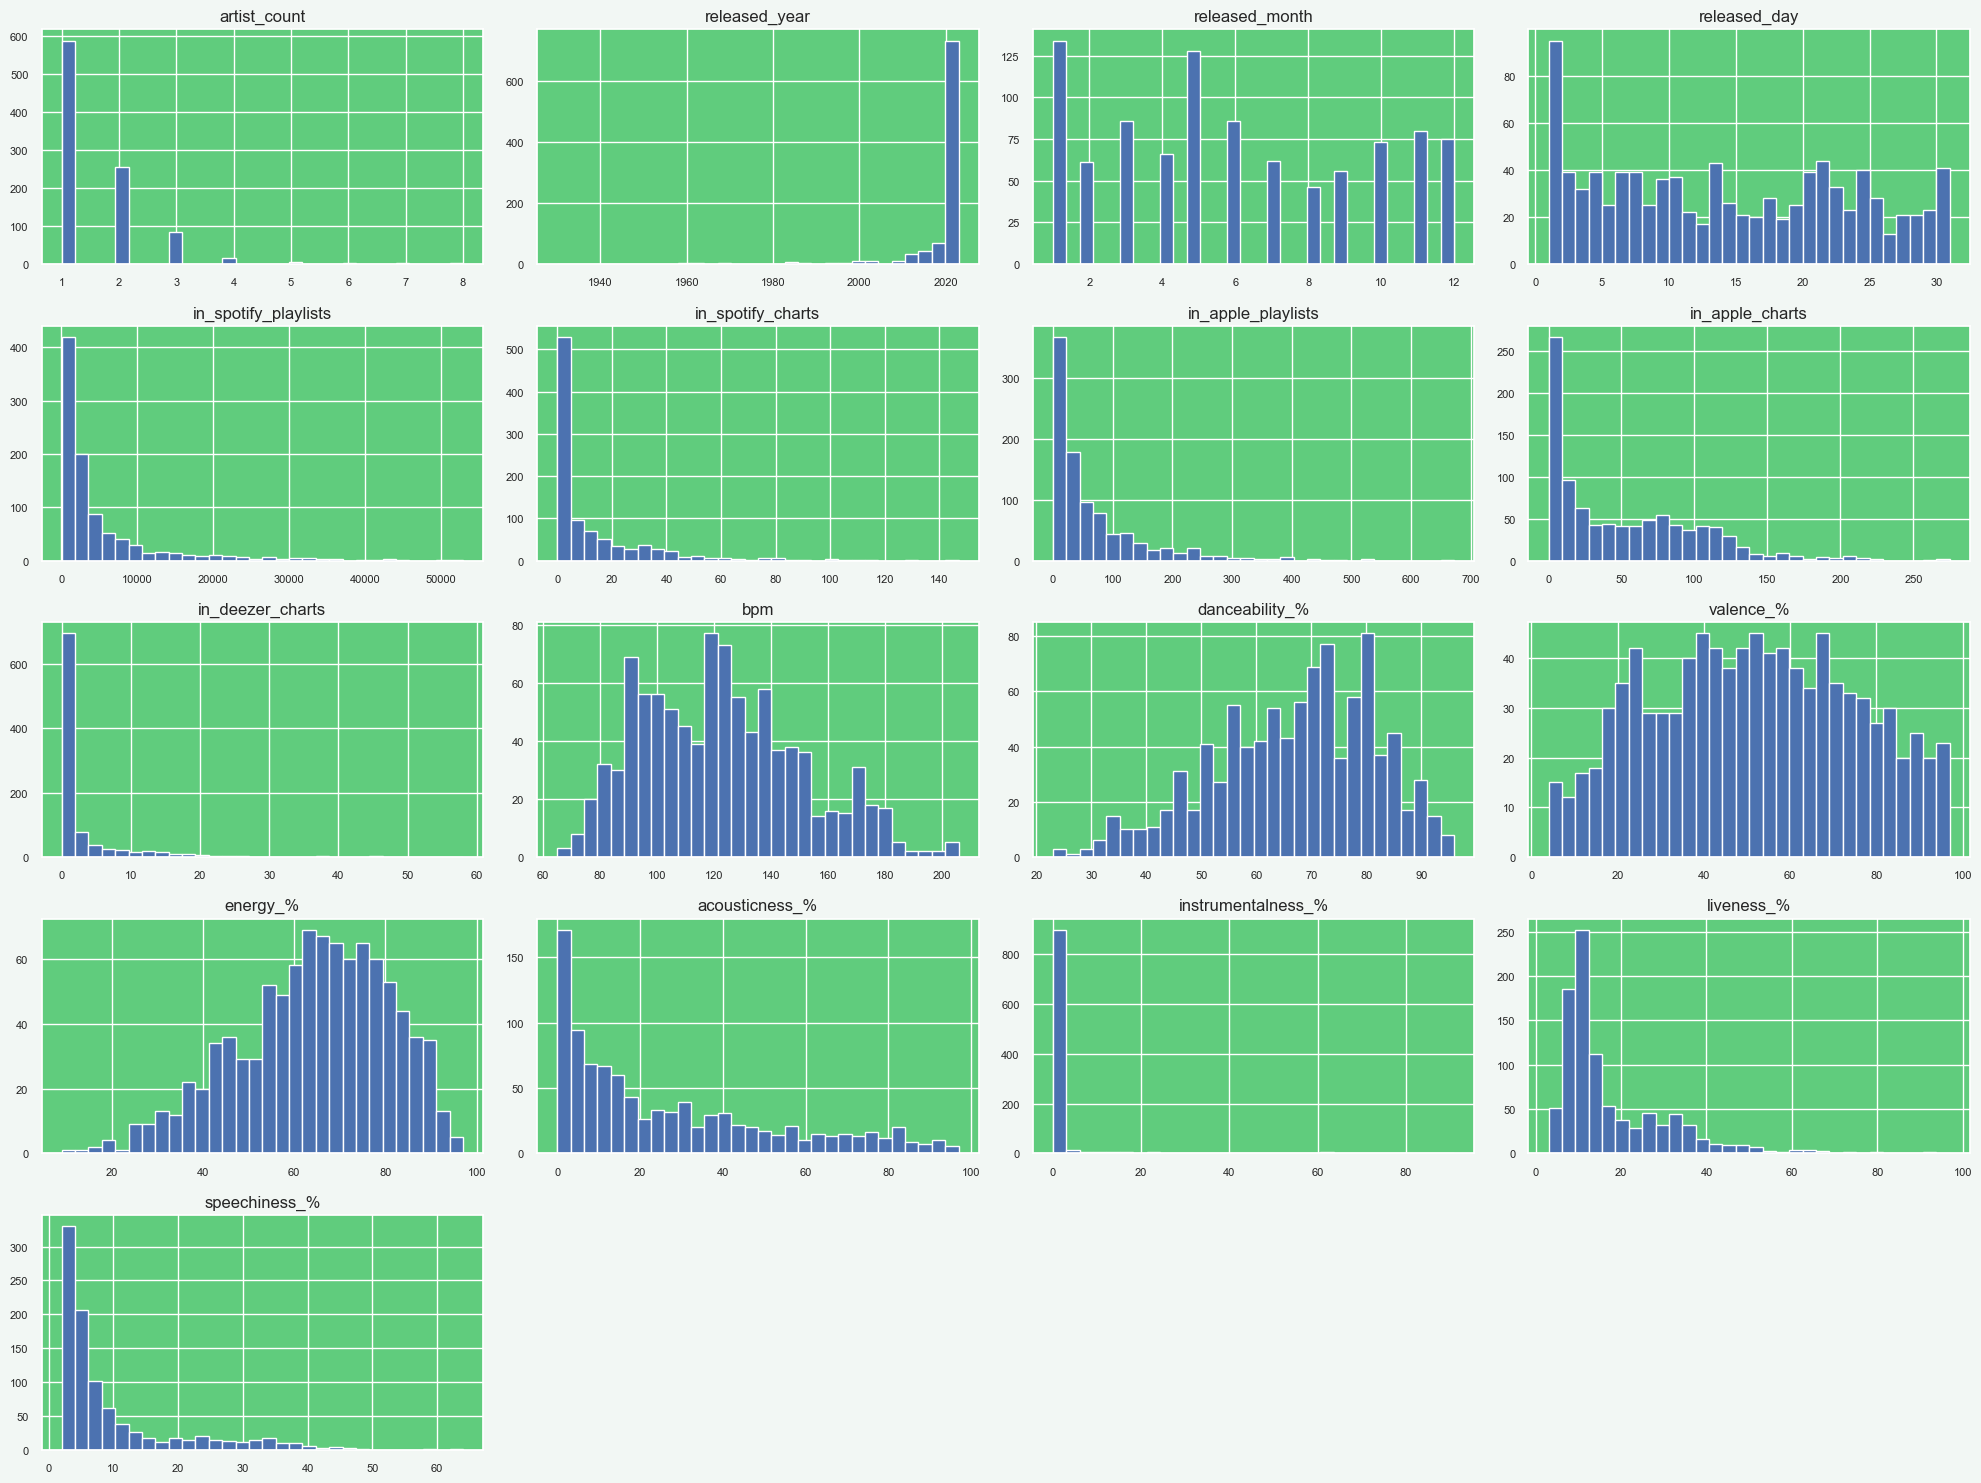

In [15]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#60cc7d","figure.facecolor":"#f2f7f4"})
numerical_cols.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

### 2.2 Categorical columns 
We need to extract all categorical columns and store them in the variable categorical_cols

In [16]:
categorical_cols = df[df.columns[(df.dtypes == 'object') | (df.dtypes == 'bool')]]
categorical_cols.shape

(953, 7)

There are 7 categorical columns, let's see 5 sample rows of them

In [17]:
categorical_cols.sample(5)

,track_name,artist(s)_name,streams,in_deezer_playlists,in_shazam_charts,key,mode
2,vampire,Olivia Rodrigo,140003974,91,949,F,Major
916,Lady Mi Amor,Feid,53987404,2,0,D,Major
215,Eyes Closed,Ed Sheeran,195576623,107,675,D,Major
778,Dos Mil 16,Bad Bunny,338422004,11,0,C#,Major
317,LA INOCENTE,"Feid, Mora",477033549,43,85,F,Minor


👉 What is the percentage of missing values?
To start our analysis, we first examined the categorical columns using the info() method.

In [18]:
categorical_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   track_name           953 non-null    object
 1   artist(s)_name       953 non-null    object
 2   streams              953 non-null    object
 3   in_deezer_playlists  953 non-null    object
 4   in_shazam_charts     903 non-null    object
 5   key                  858 non-null    object
 6   mode                 953 non-null    object
dtypes: object(7)
memory usage: 52.2+ KB


We calculated the number of missing values and percentage of missing values for each categorical column.

In [19]:
dist_categorical_cols = pd.DataFrame(
    data = {
        'Missing Values': categorical_cols.isnull().sum(),
        'Missing Percentage': (categorical_cols.isnull().mean() * 100)
    }
)
dist_categorical_cols

,Missing Values,Missing Percentage
track_name,0,0.00000
artist(s)_name,0,0.00000
streams,0,0.00000
in_deezer_playlists,0,0.00000
in_shazam_charts,50,5.24659
key,95,9.96852
mode,0,0.00000


We will examine the rows with missing values to consider how to handle them

In [20]:
categorical_cols[categorical_cols.isnull().any(axis=1)]

,track_name,artist(s)_name,streams,in_deezer_playlists,in_shazam_charts,key,mode
12,Flowers,Miley Cyrus,1316855716,745,"1,021",NaN,Major
14,As It Was,Harry Styles,2513188493,863,NaN,F#,Minor
17,What Was I Made For? [From The Motion Picture ...,Billie Eilish,30546883,95,"1,173",NaN,Major
22,I Wanna Be Yours,Arctic Monkeys,1297026226,582,73,NaN,Minor
35,Los del Espacio,"Big One, Duki, Lit Killah, Maria Becerra, FMK,...",123122413,34,184,NaN,Major
...,...,...,...,...,...,...,...
901,After LIKE,IVE,265548837,11,12,NaN,Major
903,B.O.T.A. (Baddest Of Them All) - Edit,"Interplanetary Criminal, Eliza Rose",244585109,113,0,NaN,Major
927,I Really Want to Stay at Your House,"Rosa Walton, Hallie Coggins",140430339,31,NaN,D#,Minor
938,Labyrinth,Taylor Swift,187339835,15,0,NaN,Major


In [21]:
df.describe(include=['object', 'bool'])

,track_name,artist(s)_name,streams,in_deezer_playlists,in_shazam_charts,key,mode
count,953,953,953,953,903,858,953
unique,943,645,949,348,198,11,2
top,Daylight,Taylor Swift,723894473,0,0,C#,Major
freq,2,34,2,24,344,120,550


Unique Values and Their Counts:
Major: 550 (57.71%)
Minor: 403 (42.29%)


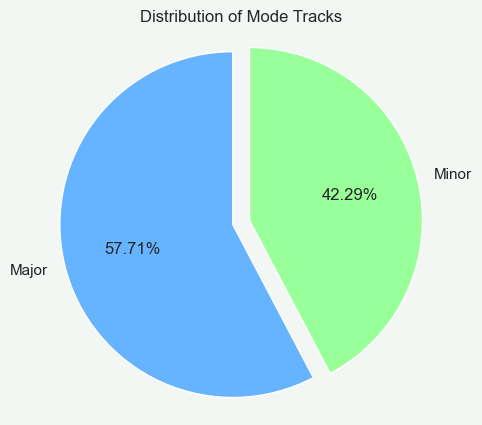

In [49]:
# Extract and print unique values and their counts
unique_values, value_counts = np.unique(categorical_cols['mode'], return_counts=True)

print("Unique Values and Their Counts:")
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count} ({(count/sum(value_counts))*100:.2f}%)")

fig, ax = plt.subplots(figsize=(5, 5))

# Explode the slice with explicit tracks for emphasis
explode = [0, 0.1]  # Only "yes" (true) will be slightly exploded
colors = ['#66b3ff','#99ff99']

ax.pie(value_counts, labels=unique_values, autopct='%1.2f%%', startangle=90, colors=colors, explode=explode)
ax.axis('equal')
ax.set_title('Distribution of Mode Tracks')
plt.show()


Unique Values and Their Counts:
Major: 550 (57.71%)
Minor: 403 (42.29%)


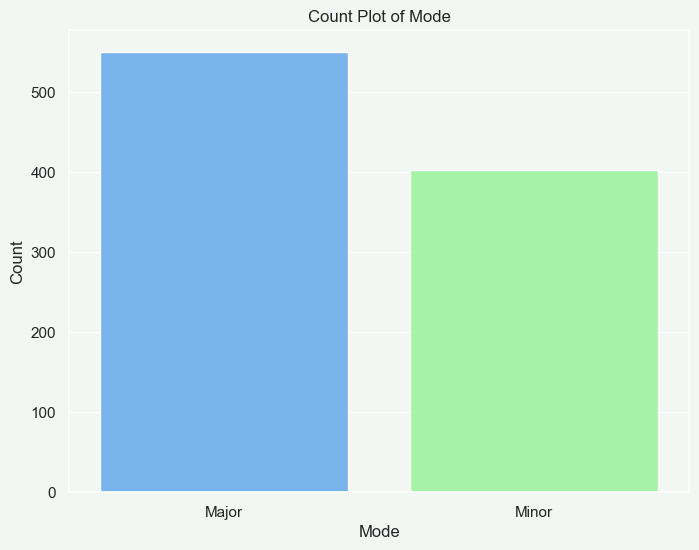

In [50]:
# Assuming df is your DataFrame and 'mode' is the column of interest
unique_values, value_counts = np.unique(df['mode'], return_counts=True)

# Print unique values and their counts
print("Unique Values and Their Counts:")
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count} ({(count/sum(value_counts))*100:.2f}%)")

# Count Plot for Mode:
plt.figure(figsize=(8, 6))
sns.countplot(x='mode', data=df, order=df['mode'].value_counts().index, palette=['#66b3ff', '#99ff99'])
plt.title('Count Plot of Mode')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.show()

👉 Top of artists, track, year, month

Top 10 Artists by Song Count:
Taylor Swift: 34 songs
The Weeknd: 22 songs
Bad Bunny: 19 songs
SZA: 19 songs
Harry Styles: 17 songs
Kendrick Lamar: 12 songs
Morgan Wallen: 11 songs
Ed Sheeran: 9 songs
BTS: 8 songs
Feid: 8 songs

Top 10 Tracks by Count:
Daylight: 2 times
About Damn Time: 2 times
SNAP: 2 times
Take My Breath: 2 times
Let It Snow! Let It Snow! Let It Snow!: 2 times
Miss You: 2 times
Numb: 2 times
Die For You: 2 times
SPIT IN MY FACE!: 2 times
Flowers: 2 times

Top 10 Years by Song Release Count:
2022: 402 songs
2023: 175 songs
2021: 119 songs
2020: 37 songs
2019: 36 songs
2017: 23 songs
2016: 18 songs
2014: 13 songs
2013: 13 songs
2015: 11 songs

Top 10 Months by Song Release Count:
1: 134 songs
5: 128 songs
3: 86 songs
6: 86 songs
11: 80 songs
12: 75 songs
10: 73 songs
4: 66 songs
7: 62 songs
2: 61 songs


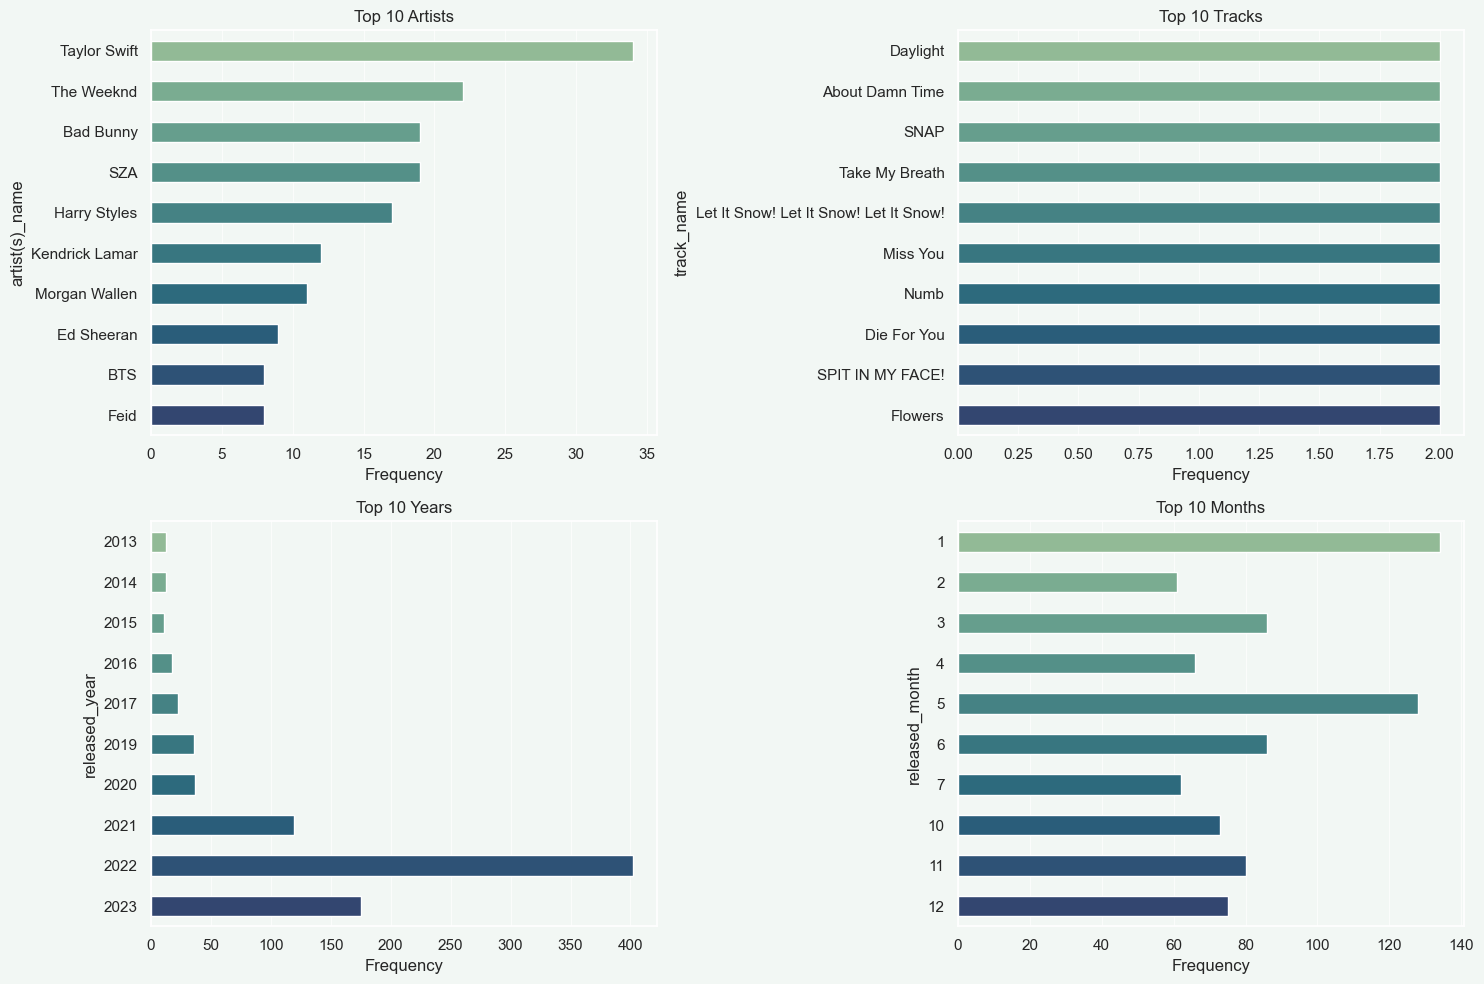

In [52]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the plots have a consistent style and background color
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor": "#f2f7f4", "figure.facecolor": "#f2f7f4"})

# Define the number of top items to extract
top_n = 10

# Extract the top N most frequent artists, tracks, years, and months
top_artists = df['artist(s)_name'].value_counts().head(top_n)
top_tracks = df['track_name'].value_counts().head(top_n)
top_years = df['released_year'].value_counts().head(top_n)
top_months = df['released_month'].value_counts().head(top_n)

# Print the top N data for each category
print("Top 10 Artists by Song Count:")
for artist, count in top_artists.items():
    print(f"{artist}: {count} songs")

print("\nTop 10 Tracks by Count:")
for track, count in top_tracks.items():
    print(f"{track}: {count} times")

print("\nTop 10 Years by Song Release Count:")
for year, count in top_years.items():
    print(f"{year}: {count} songs")

print("\nTop 10 Months by Song Release Count:")
for month, count in top_months.items():
    print(f"{month}: {count} songs")

# Suppress FutureWarnings for clean output
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # Plotting
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Top N Artists
    sns.barplot(x=top_artists.values, y=top_artists.index, palette="crest", ax=axes[0, 0], orient='h', zorder=3, width=0.5)
    axes[0, 0].set_title(f'Top {top_n} Artists')
    axes[0, 0].set_xlabel('Frequency')
    axes[0, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Tracks
    sns.barplot(x=top_tracks.values, y=top_tracks.index, palette="crest", ax=axes[0, 1], orient='h', zorder=3, width=0.5)
    axes[0, 1].set_title(f'Top {top_n} Tracks')
    axes[0, 1].set_xlabel('Frequency')
    axes[0, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Years
    sns.barplot(x=top_years.values, y=top_years.index, palette="crest", ax=axes[1, 0], orient='h', zorder=3, width=0.5)
    axes[1, 0].set_title(f'Top {top_n} Years')
    axes[1, 0].set_xlabel('Frequency')
    axes[1, 0].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    # Top N Months
    sns.barplot(x=top_months.values, y=top_months.index, palette="crest", ax=axes[1, 1], orient='h', zorder=3, width=0.5)
    axes[1, 1].set_title(f'Top {top_n} Months')
    axes[1, 1].set_xlabel('Frequency')
    axes[1, 1].xaxis.grid(linestyle='-', linewidth=0.5, alpha=1, zorder=0)

    plt.tight_layout()
    plt.show()


### 3. Abnormal values and outliers

We can observe that the distribution as well as the range of values in the numerical columns are no abnormal values so we will check outliers for some columns. We will use boxplot to visualize outliers

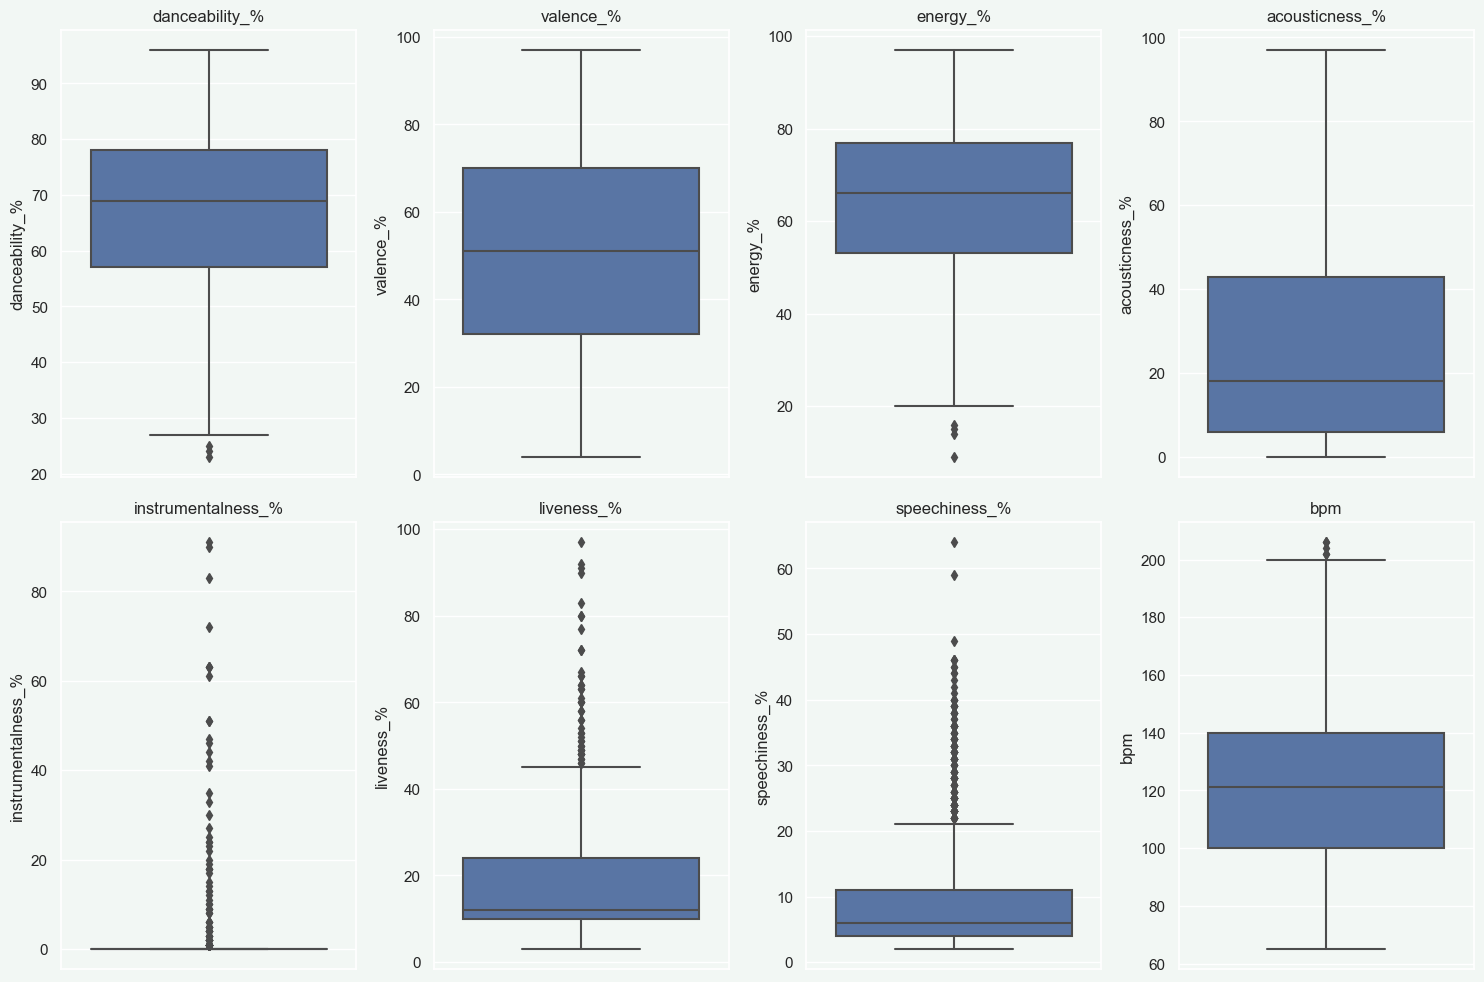

In [45]:
# boxplot for numerical columns
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":'#f2f7f4',"figure.facecolor":'#f2f7f4'})  # Fixed the syntax error here
columns = ['danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'bpm']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
for i, col in enumerate(columns):
    sns.boxplot(y=col, data=numerical_cols, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
plt.tight_layout()
plt.show()

Comment
- danceability_%, valence_%, energy_%, acousticness_%, bpm have smal amount outliers, it is not significant.
- The remaining columns exhibit a substantial number of outliers, which is understandable as they are all continuous variables. These variables have a wide range of values, do not follow a normal distribution, and are influenced by various factors of a song. Therefore, it is justifiable not to remove these outliers, as they contribute to the diversity and complexity of the dataset, reflecting the diverse nature of musical attributes.

### 4. Correlation between variables

We will use the corr() method to calculate the correlation between numerical columns and visualize it using a heatmap

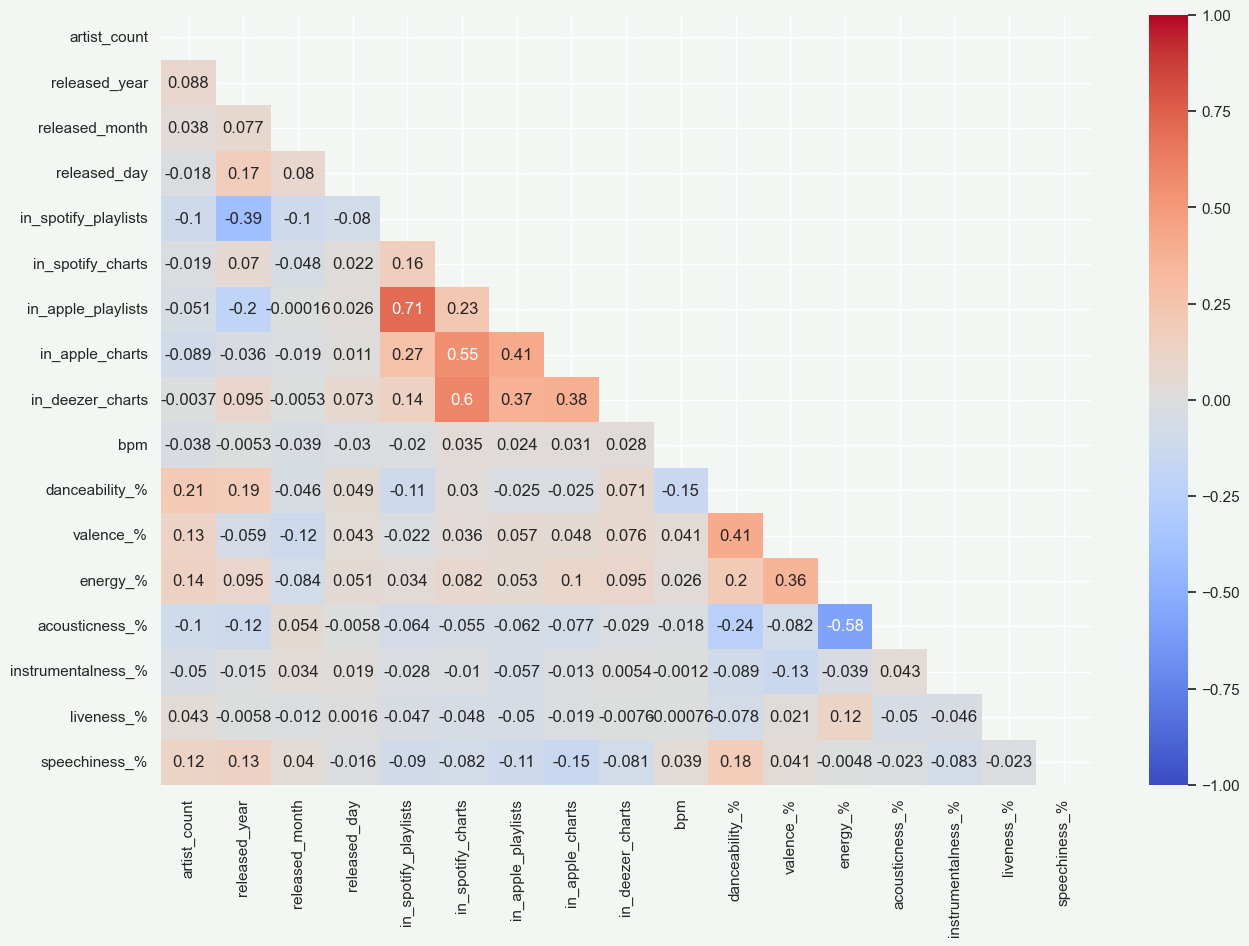

In [54]:
# Heatmap for correlation
corr = numerical_cols.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_style('white')
sns.set(rc={"axes.facecolor":"#f2f7f4","figure.facecolor":"#f2f7f4"})
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1,cmap='coolwarm')
plt.show()

### Data Visualization:

Top 10 Artists by Song Count:
Taylor Swift: 34 songs
The Weeknd: 22 songs
Bad Bunny: 19 songs
SZA: 19 songs
Harry Styles: 17 songs
Kendrick Lamar: 12 songs
Morgan Wallen: 11 songs
Ed Sheeran: 9 songs
BTS: 8 songs
Feid: 8 songs


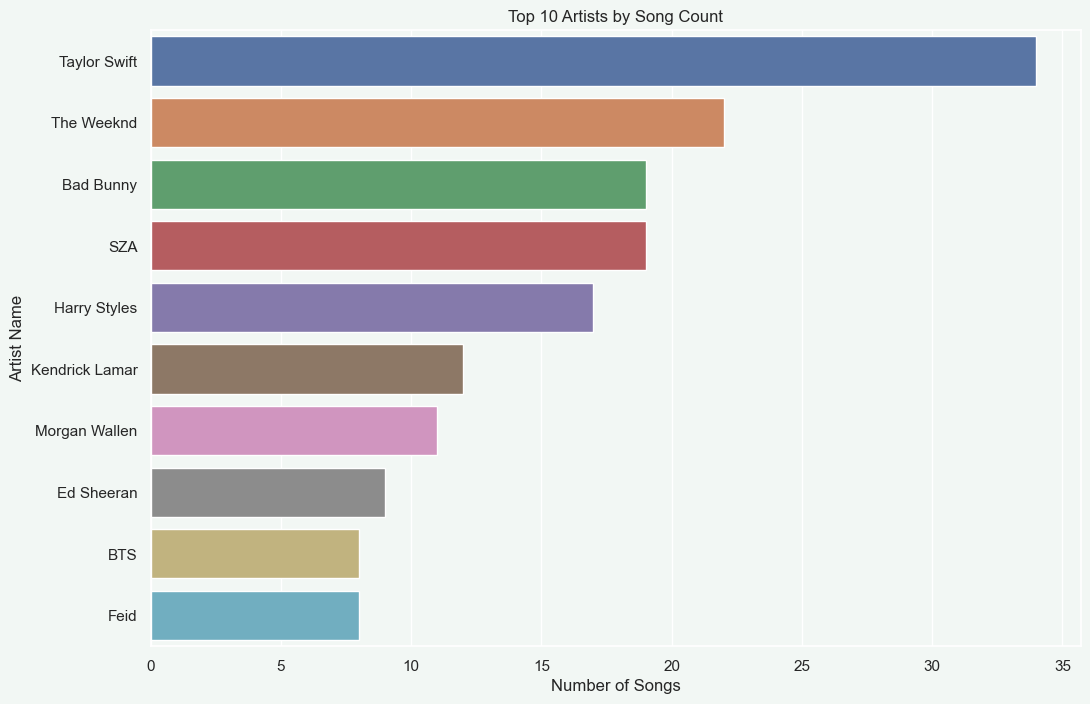

In [51]:
# Extract the top 10 artists and their song counts
top_artists = df['artist(s)_name'].value_counts().head(10)

# Print the top 10 artists along with their song counts
print("Top 10 Artists by Song Count:")
for artist, count in top_artists.items():
    print(f"{artist}: {count} songs")

# Create and display the bar plot for the top 10 artists
plt.figure(figsize=(12, 8))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='deep')
plt.title('Top 10 Artists by Song Count')
plt.xlabel('Number of Songs')
plt.ylabel('Artist Name')
plt.show()

Descriptive Statistics for Energy Percentage by Artist Count:
              count       mean        std   min   25%   50%   75%   max
artist_count                                                           
1             587.0  62.120954  17.449997   9.0  50.0  63.0  76.0  97.0
2             254.0  67.622047  14.455016  30.0  59.0  69.0  78.0  97.0
3              85.0  67.964706  14.323181  25.0  60.0  68.0  80.0  93.0
4              15.0  66.066667  15.466400  44.0  52.0  73.0  78.0  86.0
5               5.0  71.800000  14.060583  51.0  67.0  72.0  82.0  87.0
6               3.0  75.333333   4.163332  72.0  73.0  74.0  77.0  80.0
7               2.0  60.000000  21.213203  45.0  52.5  60.0  67.5  75.0
8               2.0  72.000000   5.656854  68.0  70.0  72.0  74.0  76.0


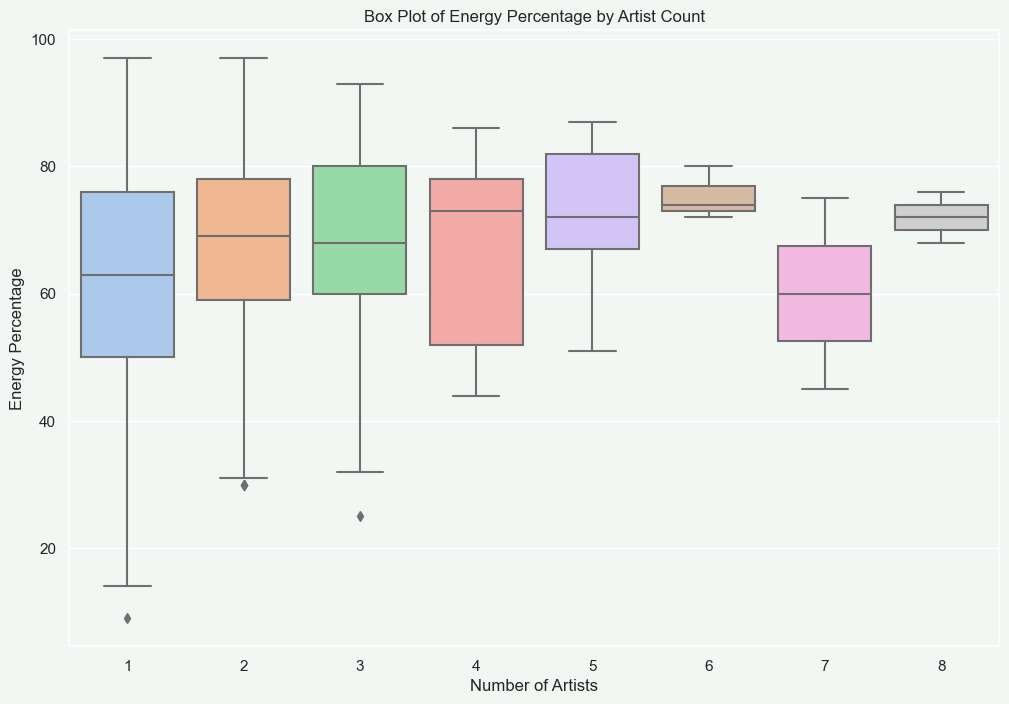

In [53]:
# Calculate descriptive statistics for energy percentage by artist count
energy_stats = df.groupby('artist_count')['energy_%'].describe()

# Print the descriptive statistics
print("Descriptive Statistics for Energy Percentage by Artist Count:")
print(energy_stats)

# Plot the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='artist_count', y='energy_%', data=df, palette='pastel')
plt.title('Box Plot of Energy Percentage by Artist Count')
plt.xlabel('Number of Artists')
plt.ylabel('Energy Percentage')
plt.show()


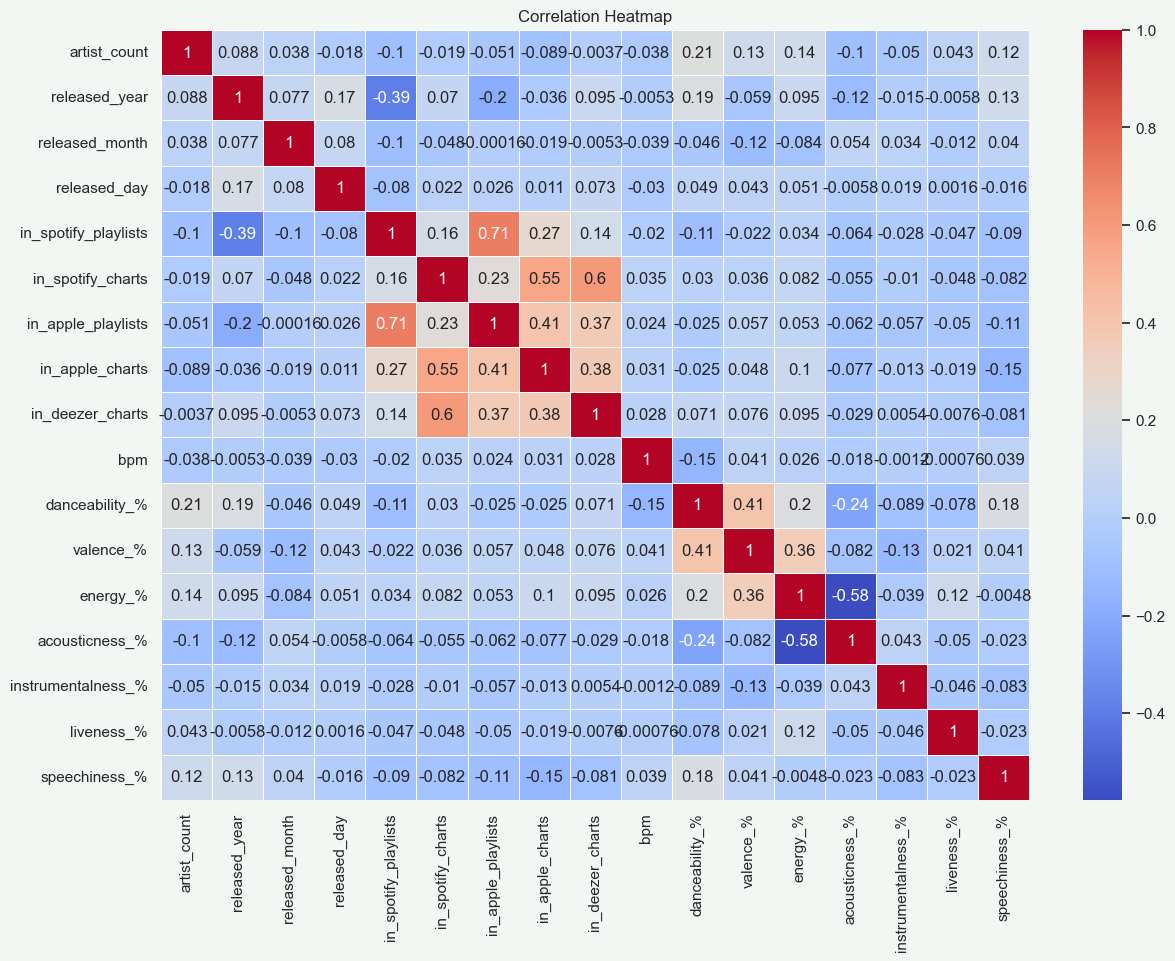

In [38]:
# Visualization: Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

/Users/irasafonik/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


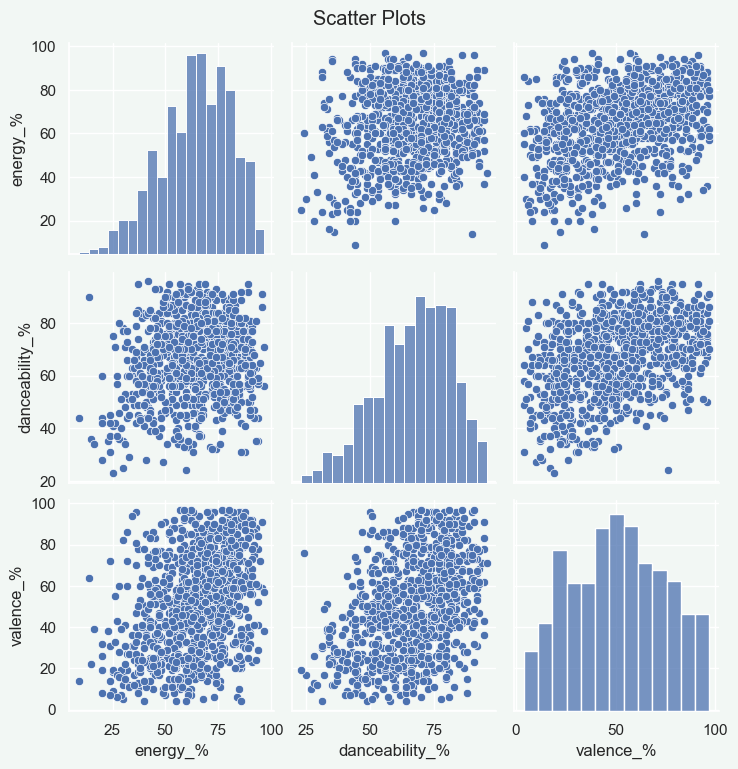

In [39]:
# Scatter Plots
sns.pairplot(df[['streams', 'energy_%', 'danceability_%', 'valence_%']])
plt.suptitle('Scatter Plots', y=1.02)
plt.show()

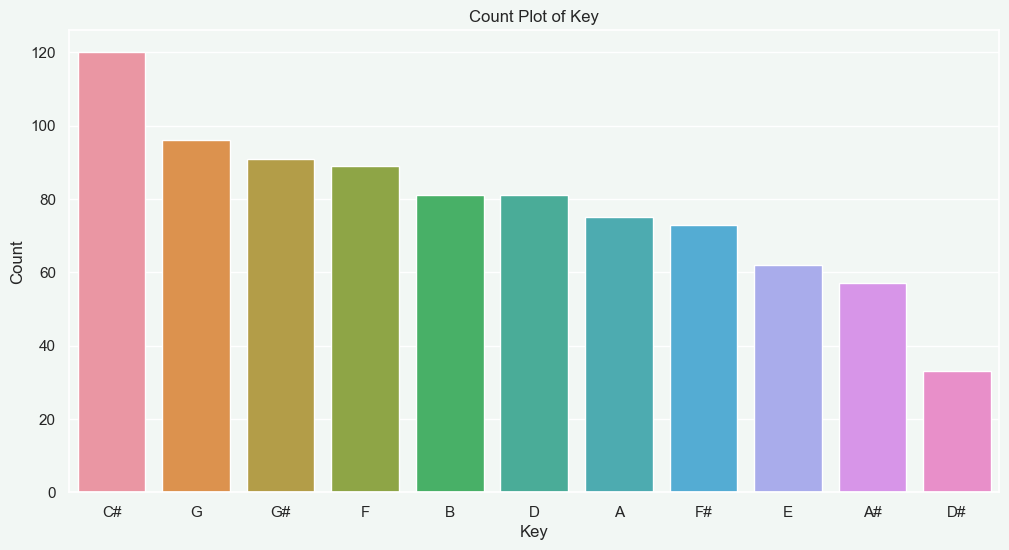

In [40]:
# Count Plot for Key:
plt.figure(figsize=(12, 6))
sns.countplot(x='key', data=df, order=df['key'].value_counts().index)
plt.title('Count Plot of Key')
plt.xlabel('Key')
plt.ylabel('Count')
plt.show()

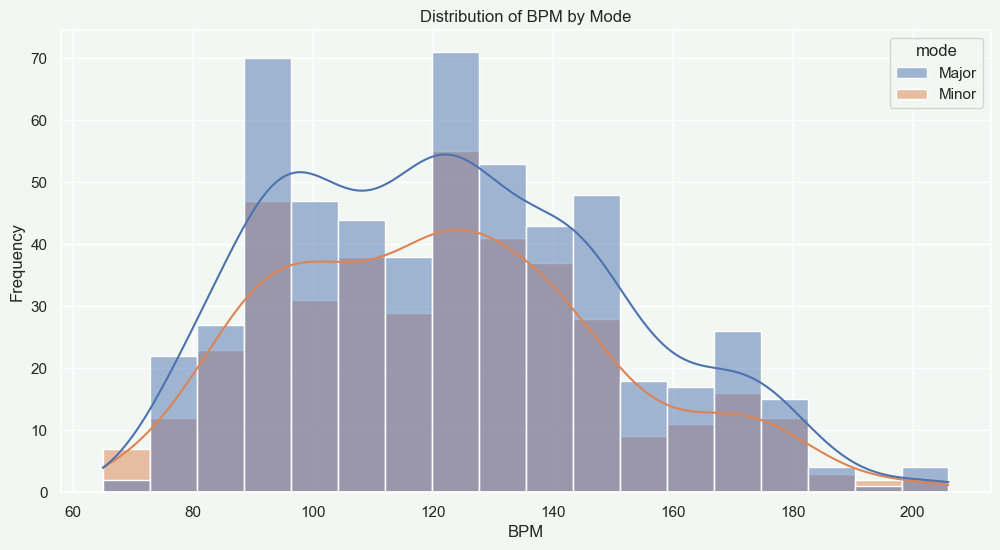

In [42]:
# Distribution of BPM by Mode:
plt.figure(figsize=(12, 6))
sns.histplot(x='bpm', data=df, hue='mode', kde=True)
plt.title('Distribution of BPM by Mode')
plt.xlabel('BPM')
plt.ylabel('Frequency')
plt.show()